# Simulacion Robot Escar 3gdl

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.proj3d import proj_transform
from mpl_toolkits.mplot3d.axes3d import Axes3D

### Clase anotacion 3d, permite colocar texto en 3d

In [2]:
from matplotlib.text import Annotation
class Annotation3D(Annotation):

    def __init__(self, text, xyz, *args, **kwargs):
        super().__init__(text, xy=(0, 0), *args, **kwargs)
        self._xyz = xyz

    def draw(self, renderer):
        x2, y2, z2 = proj_transform(*self._xyz, self.axes.M)
        self.xy = (x2, y2)
        super().draw(renderer)
        
def _annotate3D(ax, text, xyz, *args, **kwargs):
    '''Add anotation `text` to an `Axes3d` instance.'''

    annotation = Annotation3D(text, xyz, *args, **kwargs)
    ax.add_artist(annotation)

setattr(Axes3D, 'annotate3D', _annotate3D)

## Grafica lineas en 3D

In [3]:
from matplotlib.patches import FancyArrowPatch
class Arrow3D(FancyArrowPatch):

    def __init__(self, xs, ys, zs, xe, ye, ze, *args, **kwargs):
        super().__init__((0, 0), (0, 0), *args, **kwargs)
        self._xyz = (xs, ys, zs)
        self._dxdydz = (xe-xs, ye-ys, ze-zs)

    def draw(self, renderer):
        xs, ys, zs = self._xyz
        dx, dy, dz = self._dxdydz
        xe, ye, ze = (xs + dx, ys + dy, zs + dz)

        xs, ys, zs = proj_transform(xs, ys, zs, self.axes.M)
        xe, ye, ze = proj_transform(xe, ye, ze, self.axes.M)
        self.set_positions((xs,ys), (xe,ye))
        super().draw(renderer)
        
    def do_3d_projection(self, renderer=None):
        x1, y1, z1 = self._xyz
        dx, dy, dz = self._dxdydz
        x2, y2, z2 = (x1 + dx, y1 + dy, z1 + dz)

        xs, ys, zs = proj_transform((x1, x2), (y1, y2), (z1, z2), self.axes.M)
        self.set_positions((xs[0], ys[0]), (xs[1], ys[1]))

        return np.min(zs)
    
def _arrow3D(ax, xs, ys, zs, xe, ye, ze, *args, **kwargs):
    '''Add an 3d arrow to an `Axes3D` instance.'''

    arrow = Arrow3D(xs, ys, zs, xe, ye, ze, *args, **kwargs)
    ax.add_artist(arrow)


setattr(Axes3D, 'arrow3D', _arrow3D)

## Rotaciones

In [4]:
def MTHRotx(angulo):
    #Matriz de transformación homogenea, se usa la conversion de grados a radianes.
    return np.array([[1, 0, 0, 0],
                     [0, np.cos(angulo), -np.sin(angulo), 0],
                     [0, np.sin(angulo), np.cos(angulo), 0],
                     [0, 0, 0, 1]])

def MTHRoty(angulo):
    #Matriz de transformación homogenea, se usa la conversion de grados a radianes.
    return np.array([[np.cos(angulo), 0, np.sin(angulo), 0],
                     [0, 1, 0, 0],
                     [-np.sin(angulo), 0, np.cos(angulo), 0],
                     [0, 0, 0, 1]])

def MTHRotz(angulo):
    #Matriz de transformación homogenea, se usa la conversion de grados a radianes.
    return np.array([[np.cos(angulo), -np.sin(angulo), 0, 0],
                     [np.sin(angulo), np.cos(angulo), 0, 0],
                     [0, 0, 1, 0],
                     [0, 0, 0, 1]])



## Traslaciiones

In [5]:
def MTHtrasx(distancia):
    # Crear una matriz de transformación homogénea identidad 4x4
    MTH = np.eye(4)
    # Asignar la distancia a la posición en el eje x (fila 1, columna 4)
    MTH[0, 3] = distancia
    return MTH

def MTHtrasy(distancia):
    # Crear una matriz de transformación homogénea identidad 4x4
    MTH = np.eye(4)
    # Asignar la distancia a la posición en el eje x (fila 1, columna 4)
    MTH[1, 3] = distancia
    return MTH

def MTHtrasz(distancia):
    # Crear una matriz de transformación homogénea identidad 4x4
    MTH = np.eye(4)
    # Asignar la distancia a la posición en el eje x (fila 1, columna 4)
    MTH[2, 3] = distancia
    return MTH

In [6]:
def SCARA_cin_dir(q):
    # Medidas principales del robot
    L1 = 400
    L2 = 562.5
    L3 = 437.5
    G1 = 50
    A03 = MTHRotz(q[0]) @ MTHRotz(q[1])
    Px = L2 * np.cos(q[0]) + L3 * np.cos(q[0] + q[1])
    Py = L2 * np.sin(q[0]) + L3 * np.sin(q[0] + q[1])
    Pz = L1 + G1 - q[2]
    A03[0:3, 3] = [Px, Py, Pz]
    return A03

In [7]:
q = np.array([np.pi/2, -np.pi/2, 0])
SD = SCARA_cin_dir(q)
SD

array([[  1. ,   0. ,   0. , 437.5],
       [  0. ,   1. ,   0. , 562.5],
       [  0. ,   0. ,   1. , 450. ],
       [  0. ,   0. ,   0. ,   1. ]])

## Dibujar sitema de referencia

In [8]:
def dibujar_sistema_referencia_MTH(MTH, L, subindice, ax=None):
    #Esta funcion grafica un sistema de referencia a partir de una matriz de transformacion homogenea.
    
    #Puntos finales de los ejes x, y, z
    pfx = MTH @ np.array([[L], [0], [0], [1]])
    pfy = MTH @ np.array([[0], [L], [0], [1]])
    pfz = MTH @ np.array([[0], [0], [L], [1]])
    
    #Origen
    origen = np.array([MTH[0, 3], MTH[1, 3], MTH[2, 3]])
    
    #Crear figura y objeto de eje si no se proporciona uno
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        

    #Dibujar los ejes
    ax.arrow3D(origen[0], origen[1], origen[2], pfx[0, 0], pfx[1, 0], pfx[2, 0], mutation_scale=10, arrowstyle="-", linestyle='solid', color='red')
    ax.arrow3D(origen[0], origen[1], origen[2], pfy[0, 0], pfy[1, 0], pfy[2, 0], mutation_scale=10, arrowstyle="-", linestyle='solid', color='green')
    ax.arrow3D(origen[0], origen[1], origen[2], pfz[0, 0], pfz[1, 0], pfz[2, 0], mutation_scale=10, arrowstyle="-", linestyle='solid', color='blue')
    ax.annotate3D(subindice, (origen[0],origen[1],origen[2]), xytext=(3, 3), textcoords='offset points')
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.grid(True)


<function matplotlib.pyplot.show(close=None, block=None)>

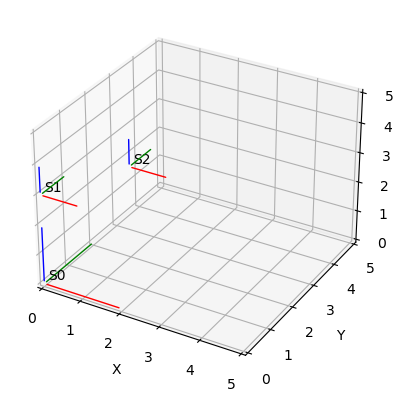

In [11]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
MTH = np.array([[1., 0., 0., 1.], [0., 1., 0., 2.],[0., 0., 1., 3.],[0., 0., 0., 1.]])
dibujar_sistema_referencia_MTH(MTH, 1, 'S2', ax)
MTH = np.array([[1., 0., 0., 0.], [0., 1., 0., 0.],[0., 0., 1., 3.],[0., 0., 0., 1.]])
dibujar_sistema_referencia_MTH(MTH, 1,'S1', ax)
dibujar_sistema_referencia_MTH(np.eye(4), 2, 'S0', ax)
ax.set_xlim(0,5)
ax.set_ylim(0,5)
ax.set_zlim(0,5)
plt.show

In [29]:
MTH = np.array([[1., 0., 0., 1.], [0., 1., 0., 2.],[0., 0., 1., 3.],[0., 0., 0., 1.]])
print(MTH)
MTH[:3, 1]

[[1. 0. 0. 1.]
 [0. 1. 0. 2.]
 [0. 0. 1. 3.]
 [0. 0. 0. 1.]]


array([0., 1., 0.])